In [1]:
!hostname

br011.ib.bridges2.psc.edu


In [2]:
from glob import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
plt.rcParams["figure.dpi"] = 150
plt.style.use("bmh")

In [4]:
results = pd.concat(
    [pd.read_csv(path) for path in sorted(glob("results/*.csv"))],
    axis=0,
    ignore_index=True,
)

In [5]:
results.head()

,method,trial,nrow,nelem,rt,val
0,dask,0,1000,10,0.236819,0.011833
1,dask,0,1000,100,0.040748,-0.002704
2,dask,0,1000,1000,0.066268,-0.005409
3,dask,0,1000,10000,0.204773,0.000062
4,dask,0,10000,10,0.034674,-0.017896


In [6]:
def q25(x):
    return np.quantile(x, 0.25)

def q75(x):
    return np.quantile(x, 0.75)

In [7]:
agg_results = results.groupby(["method", "nrow", "nelem"]).agg({"rt": ["median", q25, q75]})
agg_results.head()

rt                    
                      median       q25       q75
method nrow  nelem                              
dask   1000  10     0.072829  0.063566  0.163783
             100    0.056811  0.052095  0.068136
             1000   0.079225  0.075528  0.085420
             10000  0.257717  0.223418  0.317341
       10000 10     0.076431  0.069079  0.082677

In [8]:
summary = agg_results.loc[:, [("rt", "median")]]
summary.columns = summary.columns.get_level_values(0)
summary = summary.pivot_table(values="rt", index=["nrow", "nelem"], columns="method")

summary = summary.reset_index()
summary.columns.name = None

In [9]:
print(summary.to_markdown(index=False))

|   nrow |   nelem |       dask |     duckdb |   duckdb_v2 |      pandas |      vaex |
|-------:|--------:|-----------:|-----------:|------------:|------------:|----------:|
|   1000 |      10 |  0.0728294 | 0.00719303 |   0.0513656 |  0.00644983 | 0.0353663 |
|   1000 |     100 |  0.056811  | 0.0137391  |   0.0376955 |  0.00631348 | 0.0330512 |
|   1000 |    1000 |  0.0792249 | 0.0717905  |   0.104613  |  0.0157332  | 0.0344726 |
|   1000 |   10000 |  0.257717  | 0.548686   |   0.619418  |  0.109118   | 0.110658  |
|  10000 |      10 |  0.0764313 | 0.00909003 |   0.0425537 |  0.00987852 | 0.0343623 |
|  10000 |     100 |  0.0992361 | 0.0210544  |   0.0356032 |  0.0180061  | 0.0422467 |
|  10000 |    1000 |  0.30542   | 0.0918611  |   0.146918  |  0.112296   | 0.114463  |
|  10000 |   10000 |  1.03408   | 0.734934   |   1.02767   |  1.05573    | 0.352648  |
| 100000 |      10 |  0.152655  | 0.0225262  |   0.0513783 |  0.0420967  | 0.163559  |
| 100000 |     100 |  1.18811   | 0.0475635

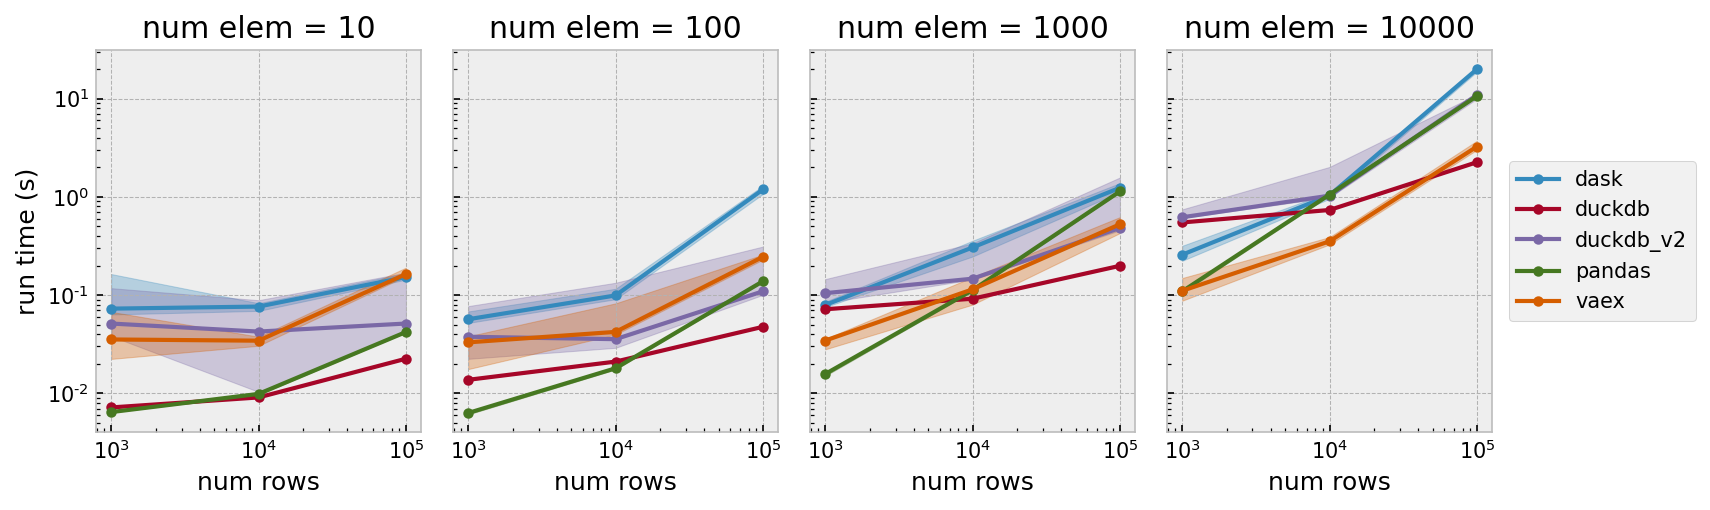

In [12]:
nr, nc = 1, 4
plotw, ploth = 2.5, 3.5
buffw, buffh = 1.5, 0.0
f, axs = plt.subplots(
    nr, nc, figsize=(nc*plotw + buffw, nr*ploth + buffh), sharey=True, sharex=True
)

nelems = [10, 100, 1000, 10000]
methods = np.unique(results["method"])

for ii, nelem in enumerate(nelems):
    axs[ii].set_yscale("log")
    axs[ii].set_xscale("log")
    plt.sca(axs[ii])
    df = agg_results.query(f"nelem == {nelem}")
    for method in methods:
        df = agg_results.loc[(method, slice(None), nelem), :]
        x = df.index.get_level_values("nrow")
        y = df.loc[:, ("rt", "median")]
        low = df.loc[:, ("rt", "q25")]
        high = df.loc[:, ("rt", "q75")]
        line = plt.plot(x, y, "o-", lw=2.0, ms=4.0, label=method)
        plt.fill_between(x, low, high, color=line[0].get_color(), alpha=0.3, label="_")

    if ii == 0:
        plt.ylabel("run time (s)")
    if ii == len(nelems) - 1:
        plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.xlabel("num rows")
    plt.title(f"num elem = {nelem}")

plt.tight_layout()
plt.savefig("figures/query_benchmark.png")